In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# LETSA
import matplotlib.dates as mdates
from datetime import datetime
import os
import time
import ast
from functools import cache

# SA
import matplotlib.patches as mpatches

# EDD
import heapq

# LETSA

In [3]:
class LETSAWorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = str(id)
        self.machines = dict_machines
        # dict_machines = {'M1': [ [], [], [] ] }

class LETSAOperation:
    def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None, predecessors=None):
        self.id = str(id)
        self.successor = str(successors) if successors else None
        self.predecessors = predecessors if predecessors else []
        self.workcenter = str(workcenter)
        self.machine = str(machine)
        self.scheduled_machine_idx = None
        self.processing_time = processing_time
        self.start_time = None
        self.end_time = None
        self.due_date = None if due_date != due_date else due_date
        self.scheduled = False

def LETSA_load_operations(df):
    """
    Loads the operation information from the df_BOM
    Initializes an Operation object for each of the operation and stores it in the operations dictionary
    Inputs: 
        - df            : a dataframe consisting the BOM information  
        - filename      : 
    Outputs:
        - operations    : 
    """

    operations = {}

    for index, row in df.iterrows():
        op = LETSAOperation(
            id=str(row['operation']),
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            due_date=row['due_date'],
            predecessors=row['predecessor_operations']
        )
        operations[op.id] = op

    for index, row in df.iterrows():
        current_op_id = row['operation']
        predecessor_ops = row['predecessor_operations']
        for predecessor in predecessor_ops:
            operations[predecessor].successor = current_op_id
    
    return operations

def LETSA_load_factory(df_machine):
    factory = {}
    for idx, row in df_machine.iterrows():
        workcenter = row['workcenter']
        dict_machines = {}
        for machine in (df_machine.columns[1:]): 
            dict_machines[machine] = [[] for _ in range(row[machine])]
        # factory.append(WorkCenter(workcenter, dict_machines=dict_machines))
        factory[workcenter] = LETSAWorkCenter(workcenter, dict_machines=dict_machines)
    return factory 

def LETSA_find_critical_path(operations, feasible_operations): 
    """
    Finds the critical path among the feasible operations.
    Inputs:
        - operations                    : dictionary {operation_id: Operation()}, a dictionary of all operations
        - feasible_operations           : list[operation_id],  a list of operation IDs that are currently feasible
    Output:
        - critical_path, critical_length
    """

    def dfs(operations, current_op_id, path, path_length, all_paths):
        """ 
        Performs recursive DFS on the operation network. 
        Inputs: 
            - operations                : dictionary {operation_id: Operation()}, dictionary of all operations 
            - current_op_id             : str, the ID of the node at which the DFS is performed
            - path                      : list, to keep track of current path
            - path_length               : float, to keep track of current path length
            - all_paths                 : list, to keep track of all possible paths 
        Output: 
            - None, perform in place
        """

        path.append(current_op_id)
        path_length += operations[current_op_id].processing_time
        
        if not operations[current_op_id].predecessors:
            all_paths.append((list(path), path_length))
        else:
            for pred in operations[current_op_id].predecessors:
                dfs(operations, pred, path, path_length, all_paths)
        
        path.pop()
        path_length -= operations[current_op_id].processing_time

    def find_all_paths(operations, feasible_operations):
        """
        Calls DFS on all the feasible operations. 
        Inputs: 
            - operations                : dictionary {operation_id: Operation()}, dictionary of all operations 
            - feasible_operations       : list [operation_id], list of all feasible operations to perform DFS on 
        """

        all_paths = []
        for op_id in feasible_operations:
            dfs(operations, op_id, [], 0, all_paths)
        return all_paths

    all_paths = find_all_paths(operations, feasible_operations)
    # print("     printing all paths")
    # for path in all_paths: 
        # print(path[0], path[1])
    critical_path, critical_length = max(all_paths, key=lambda x:x[1])

    return critical_path, critical_length

def LETSA_schedule_operations(operations, factory):
    """
    Solves the assembly scheduling problem (ASP) using the Longest End Time Scheduling Algorithm (LETSA).
    Inputs:
        - operations            : dictionary {operation_id: Operation()}, a dictionary of all operations.
        - factory               : list [WorkCenter()], a list of WorkCenter objects, containing machine information and availability
    Output:
        - scheduled_operations  : list [Operation()], a list of Operation objects with start and end time schedules.
    """

    scheduled_operations = []
    # [[Step 4]]
    i = 1
    while True:
        # print(f"Iteration {i}")
        # ================================================================================================================
        #  [[4.0]] Feasible operations = every operation that is 
        #                               (1) not scheduled, and 
        #                               (2) has all successors scheduled, OR does not have any successors
        # ================================================================================================================
        feasible_operations = [op_id for op_id, op in operations.items() if ((not op.scheduled) and (op.successor==None or operations[op.successor].scheduled))]
        # print(f"feasible operations: {feasible_operations}")
        if not feasible_operations:
            break # terminate if all operations have been scheduled

        # ===================================================================
        #  [[4.1 - 4.3]] Compute critical path only for feasible operations
        # ===================================================================
        critical_path, length = LETSA_find_critical_path(operations, feasible_operations)
        selected_operation_id = critical_path[0]
        selected_operation = operations[selected_operation_id]
        # print(f"critical path: {critical_path}, length: {length}")
        # print(f"selected operation: {selected_operation_id}")

        # =====================================================================
        # [[4.4]] Set completion/end time of the selected operation as
        #         (ii) the start time of the successor, if a successor exists
        #         (ii) the project deadline, otherwise 
        # =====================================================================
        if selected_operation.successor: 
            # if the operation has a successor 
            # then the tentative end time is the start time of the successor
            successor_id = selected_operation.successor
            tentative_completion_time = operations[successor_id].start_time
        else: 
            # else, the operation is an end product and its tentative completion time must be its own deadline
            tentative_completion_time = selected_operation.due_date

        # ============================================================================
        #   [[4.5]] For each identical machine incuded in the required work-center 
        # ============================================================================
        def check_availability(time, machine_usage): 
            """
            Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
                time            : (start, end)
                machine_usage   : list of tuples [(start1, end1), (start2, end2), ...]
            """
            start, end = time
            for interval in machine_usage:
                interval_start, interval_end = interval
                if not (end <= interval_start or start >= interval_end):
                    return False
            return True

        def find_latest_start_time(completion_time, processing_time, machine_usage):
            """
            completion_time : float
            processing_time : float
            machine_usage   : list of tuples [(start1, end1), (start2, end2), ...]
            
            Returns the latest possible start time such that the job can be completed
            before the completion time and does not overlap with any intervals in machine_usage.
            """
            latest_start_time = completion_time - processing_time

            # Sort the machine usage intervals by their start times
            machine_usage = sorted(machine_usage, key=lambda x: x[0])
            
            # Iterate over the machine usage intervals in reverse order
            for interval in reversed(machine_usage):
                interval_start, interval_end = interval
                
                # Check if there is a gap between the intervals where the job can fit
                if interval_end <= latest_start_time:
                    if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                        return latest_start_time
                latest_start_time = min(latest_start_time, interval_start - processing_time)
            
            # Check if the latest possible start time is valid
            if check_availability((latest_start_time, latest_start_time + processing_time), machine_usage):
                return latest_start_time
            
            return None

        current_workcenter_id = str(selected_operation.workcenter)
        # print(type(current_workcenter_id))
        # print(factory)
        current_workcenter = factory[current_workcenter_id]             # WorkCenter object 
        machine_type = str(selected_operation.machine)                  # machine id of required machine
        possible_machines = current_workcenter.machines[machine_type]   # [[], [], []]

        processing_time = selected_operation.processing_time
        tentative_start_time = tentative_completion_time - processing_time
        possible_start_times = []
        for machine_idx, machine_schedule in enumerate(possible_machines):
            # print(machine_idx, machine_schedule)
            # if not machine_schedule:  # If machine schedule is empty, then machine is immediately useable
            #     latest_available_start_time = tentative_completion_time - selected_operation.processing_time
            if check_availability((tentative_start_time, tentative_completion_time), machine_schedule) :
                start_time, end_time = tentative_start_time, tentative_completion_time
            else: 
                start_time = find_latest_start_time(tentative_completion_time, processing_time, machine_schedule) 
                end_time = start_time + processing_time
            possible_start_times.append((machine_idx, start_time, end_time))
            # print(start_time, end_time)

        # ============================================================================
        #   [[4.6]] Select a machine to schedule operation Jc  
        # ============================================================================
        selected_machine, finalized_start_time, finalized_end_time = max(possible_start_times, key=lambda x:x[1]) 
        current_workcenter.machines[machine_type][machine_idx].append((finalized_start_time, finalized_end_time))

        # ============================================================================
        #   [[4.7]] Delete operation Jc from the network
        #   [[4.8]] Add all eligible operations into the list of feasible operations     
        # ============================================================================
        selected_operation.start_time = start_time
        selected_operation.end_time = end_time
        selected_operation.scheduled = True
        selected_operation.scheduled_machine_idx = selected_machine
        scheduled_operations.append(selected_operation)

        i += 1 
        # print()
        
    return scheduled_operations

def LETSA_plot_gantt_chart(scheduled_operations, plot_path=None, plot_name=None):   
    fig, ax = plt.subplots(figsize=(20, 20))

    # Get unique work centers
    workcenters = list(set(str(op.workcenter) for op in scheduled_operations))
    # print(f"Unique workcenters: {workcenters}")
    # print(workcenters)

    # Generate colors for each work center
    available_colors = plt.cm.tab20.colors
    num_colors = len(available_colors)
    colors = {workcenter: available_colors[i % num_colors] for i, workcenter in enumerate(workcenters)}
    # print(f"Colors dictionary: {colors}")

    for op in scheduled_operations:
        workcenter = str(op.workcenter)
        # print(f"Processing operation {op.id} for workcenter {workcenter}")
        
        start = op.start_time
        end = op.end_time
        
        if workcenter not in colors:
            print(f"Workcenter {workcenter} not found in colors dictionary")
            continue
        
        ax.barh(workcenter, end - start, left=start, color=colors[workcenter], edgecolor='black')
        ax.text(start + (end - start) / 2, workcenter, op.id, ha='center', va='center', color='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Work Center')
    ax.set_title('Gantt Chart of LETSA schedule')
    ax.set_yticks(range(len(workcenters)))
    ax.set_yticklabels(workcenters)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    if plot_path: 
        plt.savefig(f"{plot_path}//{plot_name}.png")
        plt.close(fig)
        plt.clf()

def LETSA_calculate_makespan(factory):
    list_schedules = []
    for workcenter_key in factory:
        for _, machine_schedule in factory[workcenter_key].machines.items():
            flattened_schedule = [item for sublist in machine_schedule for item in sublist]
            list_schedules += flattened_schedule

    _max = max(list_schedules, key=lambda x: x[1])[1]
    _min = min(list_schedules, key=lambda x: x[0])[0]

    return _max - _min

def LETSA_format_schedule(scheduled_operations):
    df_schedule = pd.DataFrame({ 'PercentCompletion': [100 for _ in range(len(scheduled_operations))] })
    for i, operation in enumerate(scheduled_operations): 
        df_schedule.at[i, "Operation"] = operation.id
        df_schedule.at[i, "WorkCenter"] = operation.workcenter
        df_schedule.at[i, "Machine"] = operation.machine
        df_schedule.at[i, "Machine"] = operation.scheduled_machine_idx
        df_schedule.at[i, "Start"] = operation.start_time
        df_schedule.at[i, "End"] = operation.start_time + operation.processing_time

    return df_schedule


In [4]:
# df_BOM = pd.DataFrame({
#     'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
#     'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
#     'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
#     'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
#     'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
#     'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
#     'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
# })
# df_machine = pd.DataFrame({
#     'workcenter': ["WC#1", "WC#2", "WC#3"],
#     'M1': [3, 2, 3],
#     'M2': [2, 1, 2],
#     'M3': [1, 2, 1],
#     'M4': [1, 1, 1],
#     'M5': [1, 2, 3]
# })
# factory = LETSA_load_factory(df_machine)
# operations = LETSA_load_operations(df_BOM)
# scheduled_operations = LETSA_schedule_operations(operations, factory)
# df_schedule = LETSA_format_schedule(scheduled_operations)
# display(df_schedule)

# EDD

In [23]:
# ==============
#     EDD
# ==============
class EDDOperation:
    def __init__(self, id, predecessor_operations, end_product, due_date, processing_time, workcenter, machine):
        self.id = str(id)
        self.predecessor_operations = predecessor_operations
        self.end_product = end_product
        self.due_date = due_date
        self.processing_time = processing_time
        self.workcenter = str(workcenter)
        self.machine = str(machine)
        self.scheduled_machine_idx = None
        self.start_time = None
        self.end_time = None
        self.scheduled = False

class EDDWorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = str(id)
        self.machines = dict_machines

def EDD_load_operations(df):
    operations = {}
    for _, row in df.iterrows():
        op_id = row['operation']
        operations[op_id] = EDDOperation(
            id=op_id,
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            predecessor_operations=row['predecessor_operations'] if isinstance(row['predecessor_operations'], list) else [],
            end_product=row['end_product'],
            due_date=row['due_date']
        )
    return operations

def EDD_load_factory(df_machine):
    factory = {}
    for _, row in df_machine.iterrows():
        workcenter_id = row['workcenter']
        machines = {machine: [] for machine in df_machine.columns[1:] if row[machine] > 0}
        factory[workcenter_id] = EDDWorkCenter(id=workcenter_id, dict_machines=machines)
    return factory

def EDD_find_earliest_start_time(machine_usage, desired_start_time, processing_time):
    """
    Finds the earliest start time on the given machine that avoids overlapping with existing jobs.
    """
    # Ensure machine_usage is a list of tuples
    if not all(isinstance(interval, tuple) and len(interval) == 2 for interval in machine_usage):
        raise ValueError("Machine usage must be a list of tuples with exactly two values each.")
    
    # Flatten the list of usage intervals
    flat_usage = [interval for interval in machine_usage]
    flat_usage.sort()
    
    # print(f"Machine usage: {flat_usage}")
    # print(f"Desired start time: {desired_start_time}, Processing time: {processing_time}")

    if not flat_usage:
        return desired_start_time

    for i in range(len(flat_usage) + 1):
        if i == 0:
            interval_start = 0
            interval_end = flat_usage[i][0] if len(flat_usage) > 0 else float('inf')
        elif i == len(flat_usage):
            interval_start = flat_usage[i - 1][1]
            interval_end = float('inf')
        else:
            interval_start = flat_usage[i - 1][1]
            interval_end = flat_usage[i][0]

        # print(f"Checking interval: ({interval_start}, {interval_end})")

        if desired_start_time >= interval_start and desired_start_time + processing_time <= interval_end:
            return desired_start_time

        if interval_start + processing_time <= interval_end:
            return interval_start

    return desired_start_time

def EDD_schedule_operations(operations, factory):
    def check_availability(start_time, processing_time, machine_usage):
        """
        Returns True if the time interval does not overlap with any intervals in machine_usage, False otherwise.
        """
        end_time = start_time + processing_time
        for interval in machine_usage:
            if len(interval) != 2:
                raise ValueError("Machine usage interval does not contain exactly 2 values")
            interval_start, interval_end = interval
            if not (end_time <= interval_start or start_time >= interval_end):
                return False
        return True

    scheduled_operations = []
    Q = []
    unscheduled_dependencies = {op_id: len(op.predecessor_operations) for op_id, op in operations.items()}

    # Initialize the queue with operations that have no dependencies, sorted by due dates
    for op_id, count in unscheduled_dependencies.items():
        if count == 0:
            heapq.heappush(Q, (operations[op_id].due_date if operations[op_id].due_date is not None else float('inf'), operations[op_id].processing_time, op_id))

    while Q:
        _, _, operation_id = heapq.heappop(Q)
        operation = operations[operation_id]

        if operation.scheduled:
            continue

        # Compute start time based on dependencies
        if operation.predecessor_operations:
            max_end_time = max(
                (operations[comp_id].end_time if operations[comp_id].end_time is not None else -float('inf'))
                for comp_id in operation.predecessor_operations
            )
            operation.start_time = max_end_time
        else:
            operation.start_time = 0

        # Find the best machine and start time
        workcenter = factory[str(operation.workcenter)]
        best_start_time = float('inf')
        selected_machine = None
        selected_machine_name = None
        
        for machine_name, machine_usages in workcenter.machines.items():
            # print(f"Machine: {machine_name}, Usages: {machine_usages}")
            
            # Ensure machine_usages is a list of tuples
            if not all(isinstance(interval, tuple) and len(interval) == 2 for interval in machine_usages):
                raise ValueError(f"Machine usages for {machine_name} in workcenter {operation.workcenter} must be a list of tuples with exactly two values each.")
                
            start_time = EDD_find_earliest_start_time(machine_usages, operation.start_time, operation.processing_time)
            if check_availability(start_time, operation.processing_time, machine_usages):
                if start_time < best_start_time:
                    best_start_time = start_time
                    selected_machine = machine_usages
                    selected_machine_name = machine_name

        if selected_machine is None:
            # No available machine found; push operation back to recheck later
            heapq.heappush(Q, (operation.due_date if operation.due_date is not None else float('inf'), operation.processing_time, operation_id))
            # print(f"Operation {operation.id} not scheduled yet, re-adding to the queue")
            continue

        # Schedule the operation
        operation.start_time = best_start_time
        operation.end_time = operation.start_time + operation.processing_time
        operation.scheduled_machine_idx = selected_machine_name
        selected_machine.append((operation.start_time, operation.end_time))
        selected_machine.sort()

        # # Debug information
        # print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {selected_machine_name} in workcenter {operation.workcenter}")
        # print(f"Machine {selected_machine_name} in workcenter {operation.workcenter} usage after scheduling operation {operation.id}: {selected_machine}")

        operation.scheduled = True
        scheduled_operations.append(operation)

        # Update dependencies and add ready operations to the queue
        for op_id, op in operations.items():
            if not op.scheduled and op_id in unscheduled_dependencies:
                for comp_id in op.predecessor_operations:
                    if operations[comp_id].scheduled:
                        unscheduled_dependencies[op_id] -= 1
                if unscheduled_dependencies[op_id] == 0:
                    heapq.heappush(Q, (op.due_date if op.due_date is not None else float('inf'), op.processing_time, op_id))
                    # print(f"Operation {op_id} with no remaining dependencies added to the queue")

    # Check if all operations have been scheduled
    unscheduled_ops = [op_id for op_id, op in operations.items() if not op.scheduled]
    if unscheduled_ops:
        # print(f"Unscheduled operations remaining: {unscheduled_ops}")
        # Attempt to schedule remaining unscheduled operations
        for op_id in unscheduled_ops:
            operation = operations[op_id]
            # Compute start time based on dependencies
            if operation.predecessor_operations:
                max_end_time = max(
                    (operations[comp_id].end_time if operations[comp_id].end_time is not None else -float('inf'))
                    for comp_id in operation.predecessor_operations
                )
                operation.start_time = max_end_time
            else:
                operation.start_time = 0

            # Find the best machine and start time
            workcenter = factory[operation.workcenter]
            best_start_time = float('inf')
            selected_machine = None
            selected_machine_name = None
            
            for machine_name, machine_usages in workcenter.machines.items():
                # print(f"Machine: {machine_name}, Usages: {machine_usages}")
                
                # Ensure machine_usages is a list of tuples
                if not all(isinstance(interval, tuple) and len(interval) == 2 for interval in machine_usages):
                    raise ValueError(f"Machine usages for {machine_name} in workcenter {operation.workcenter} must be a list of tuples with exactly two values each.")
                    
                start_time = EDD_find_earliest_start_time(machine_usages, operation.start_time, operation.processing_time)
                if check_availability(start_time, operation.processing_time, machine_usages):
                    if start_time < best_start_time:
                        best_start_time = start_time
                        selected_machine = machine_usages
                        selected_machine_name = machine_name

            if selected_machine is None:
                # print(f"Operation {operation.id} could not be scheduled")
                continue

            # Schedule the operation
            operation.start_time = best_start_time
            operation.end_time = operation.start_time + operation.processing_time
            selected_machine.append((operation.start_time, operation.end_time))
            selected_machine.sort()

            # # Debug information
            # print(f"Operation {operation.id}: Scheduled from {operation.start_time} to {operation.end_time} on machine {selected_machine_name} in workcenter {operation.workcenter}")
            # print(f"Machine {selected_machine_name} in workcenter {operation.workcenter} usage after scheduling operation {operation.id}: {selected_machine}")

            operation.scheduled = True
            scheduled_operations.append(operation)

    return scheduled_operations

def EDD_calculate_makespan(scheduled_operations):
    list = []
    for operation in scheduled_operations: 
        start_time = operation.start_time
        end_time = operation.end_time 
        list.append(start_time)
        list.append(end_time)
    start = min(list)
    end = max(list)
    return end - start

# def EDD_format_schedule(scheduled_operations):


In [25]:
def plot_gantt_chart(scheduled_operations, plot_path=None, plot_name=None):   
    fig, ax = plt.subplots(figsize=(20, 20))

    # Get unique work centers
    workcenters = list(set(str(op.workcenter) for op in scheduled_operations))

    # Generate colors for each work center
    available_colors = plt.cm.tab20.colors
    num_colors = len(available_colors)
    colors = {workcenter: available_colors[i % num_colors] for i, workcenter in enumerate(workcenters)}

    for op in scheduled_operations:
        workcenter = str(op.workcenter)
        
        start = op.start_time
        end = op.end_time
        
        if workcenter not in colors:
            print(f"Workcenter {workcenter} not found in colors dictionary")
            continue
        
        ax.barh(workcenter, end - start, left=start, color=colors[workcenter], edgecolor='black')
        ax.text(start + (end - start) / 2, workcenter, op.id, ha='center', va='center', color='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Work Center')
    ax.set_title('Gantt Chart of EDD schedule')
    ax.set_yticks(range(len(workcenters)))
    ax.set_yticklabels(workcenters)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    if plot_path: 
        plt.savefig(f"{plot_path}//{plot_name}.png")
        plt.close(fig)
        plt.clf()

def plot_gantt_chart_by_workcenters(scheduled_operations, plot_path=None, plot_name=None):
    # Create a dictionary to store operations by work centers and machines
    workcenter_machine_operations = {}
    
    for op in scheduled_operations:
        key = (op.workcenter, op.machine)
        if key not in workcenter_machine_operations:
            workcenter_machine_operations[key] = []
        workcenter_machine_operations[key].append(op)
    
    # Create a new figure for each work center
    workcenters = list(set(op.workcenter for op in scheduled_operations))
    num_workcenters = len(workcenters)
    
    for workcenter in workcenters:
        fig, ax = plt.subplots(figsize=(20, 10))
        machines = [machine for wc, machine in workcenter_machine_operations.keys() if wc == workcenter]
        
        for i, machine in enumerate(machines):
            ops = [op for wc, mach in workcenter_machine_operations.keys() if wc == workcenter and mach == machine
                   for op in workcenter_machine_operations[(wc, mach)]]
            
            for op in ops:
                start = op.start_time
                end = op.end_time
                ax.barh(f"{workcenter} - {machine}", end - start, left=start, color='skyblue', edgecolor='black')
                ax.text(start + (end - start) / 2, f"{workcenter} - {machine}", op.id, ha='center', va='center', color='black')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Machine')
        ax.set_title(f'Gantt Chart for Work Center {workcenter}')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        if plot_path:
            plt.savefig(f"{plot_path}/{workcenter}_{plot_name}.png")
        plt.show()
        plt.close(fig)




,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


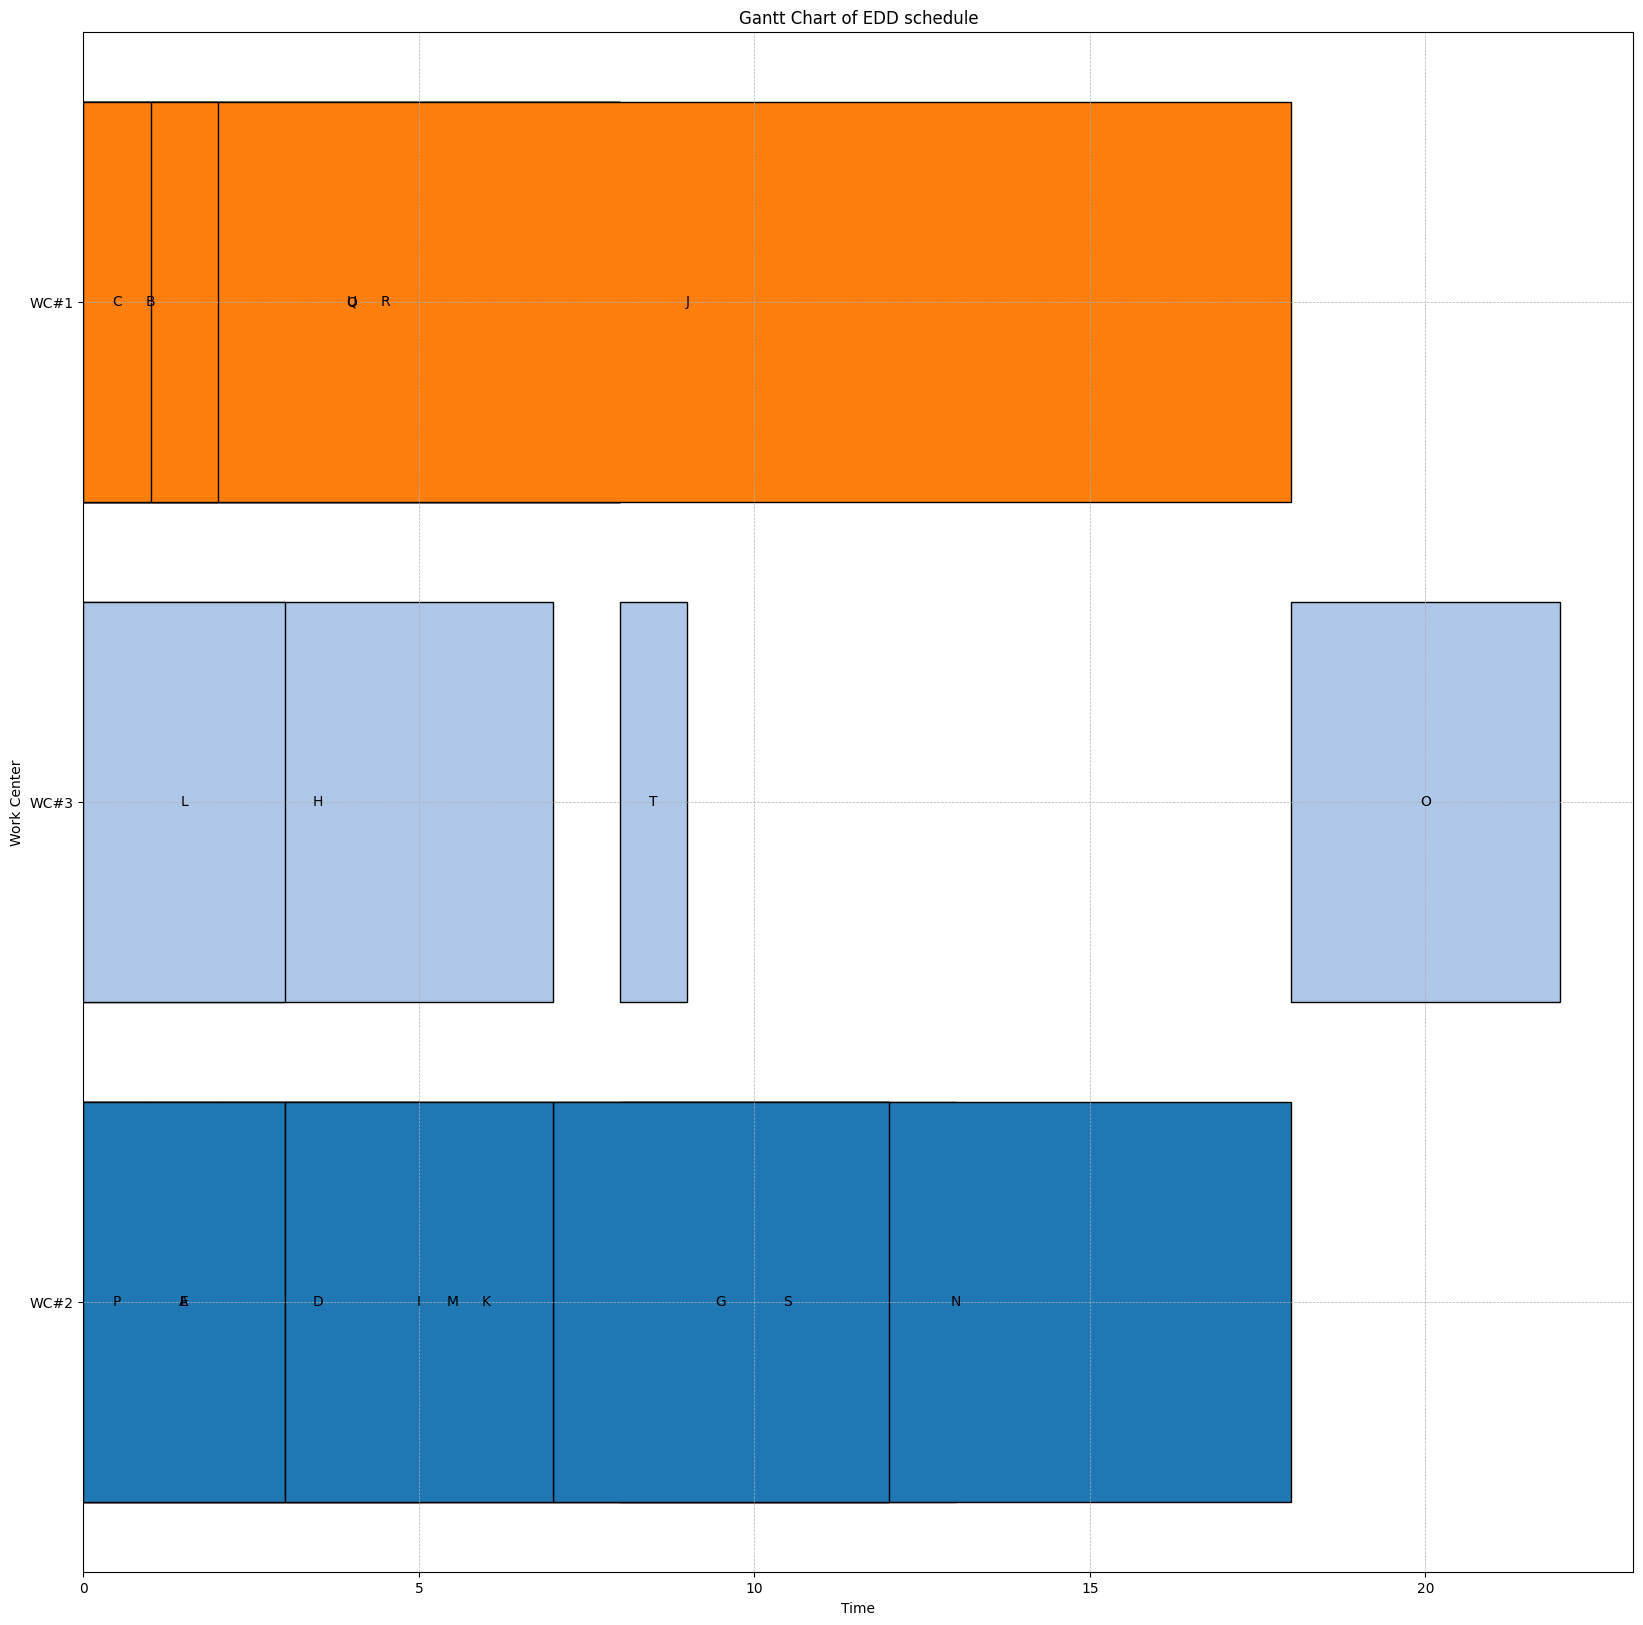

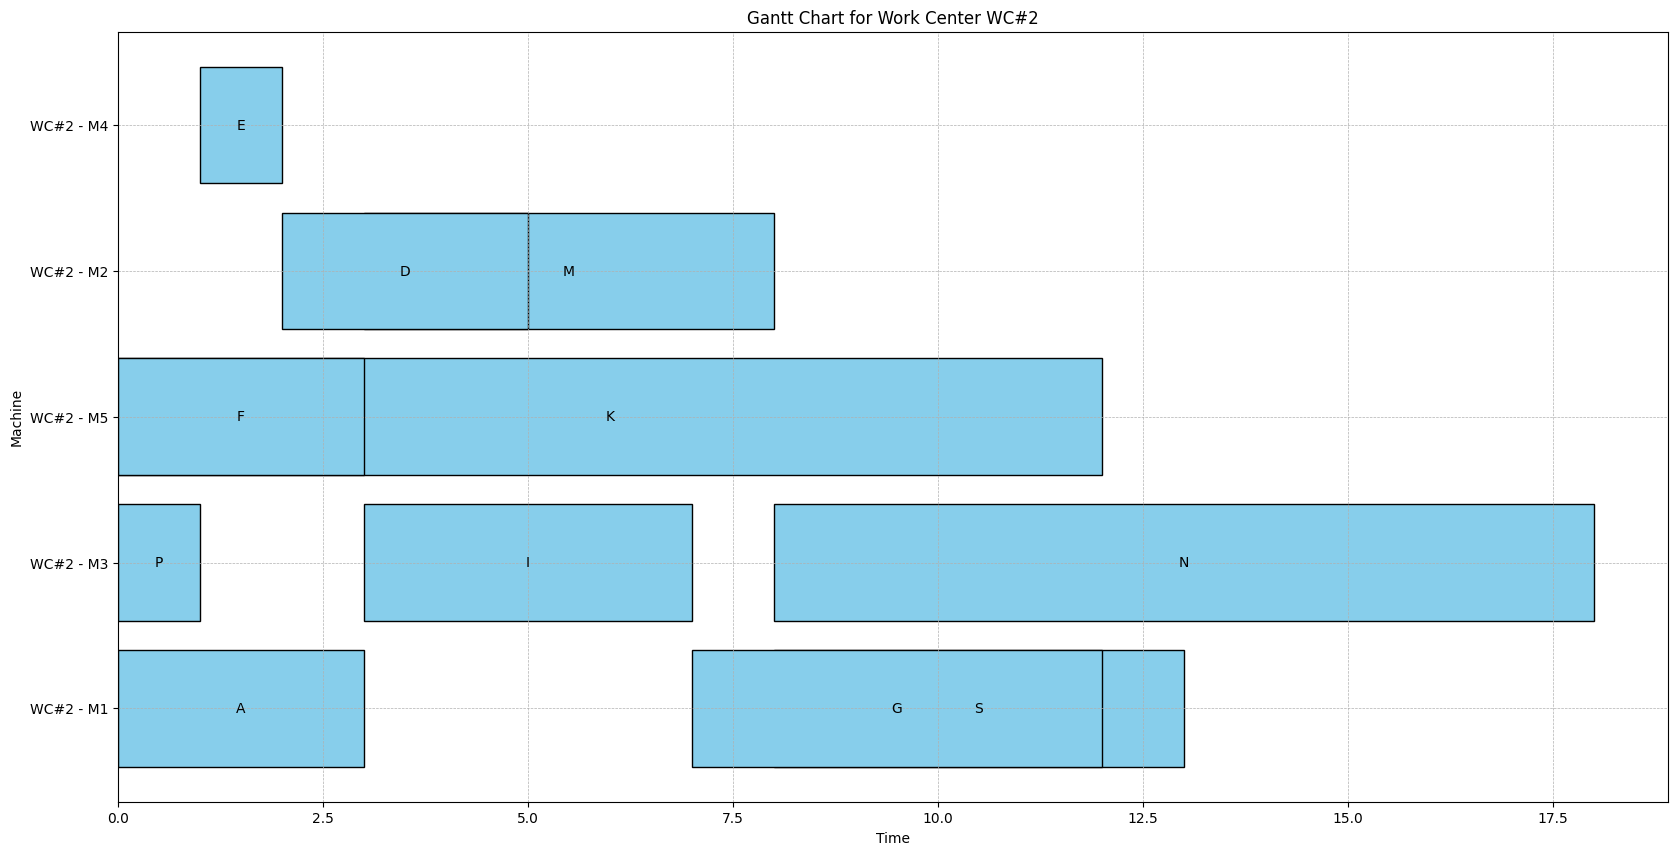

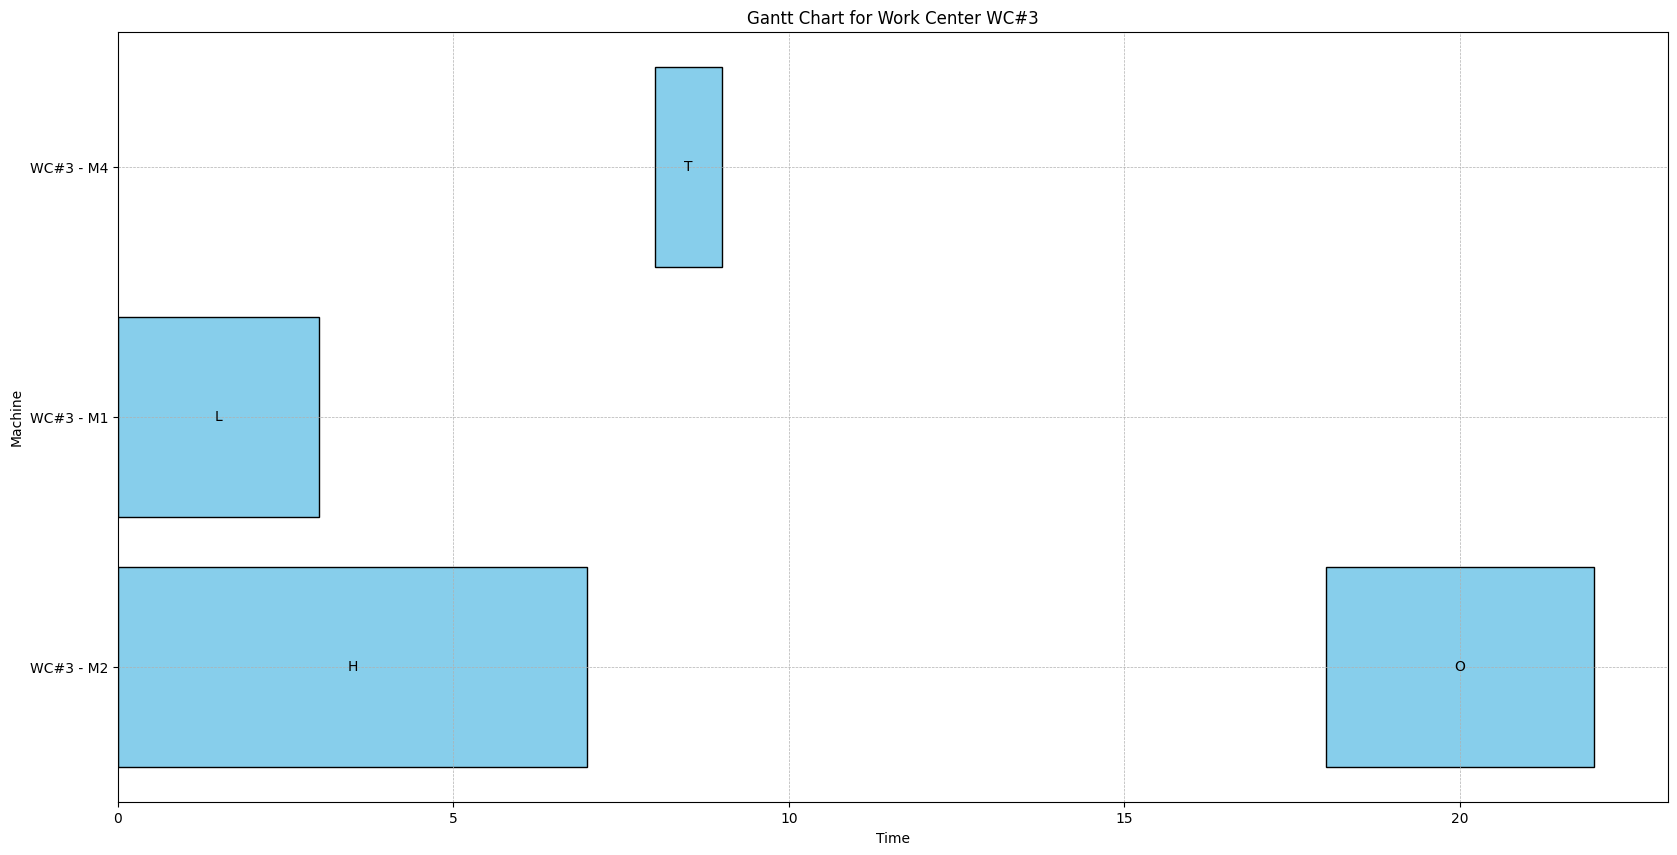

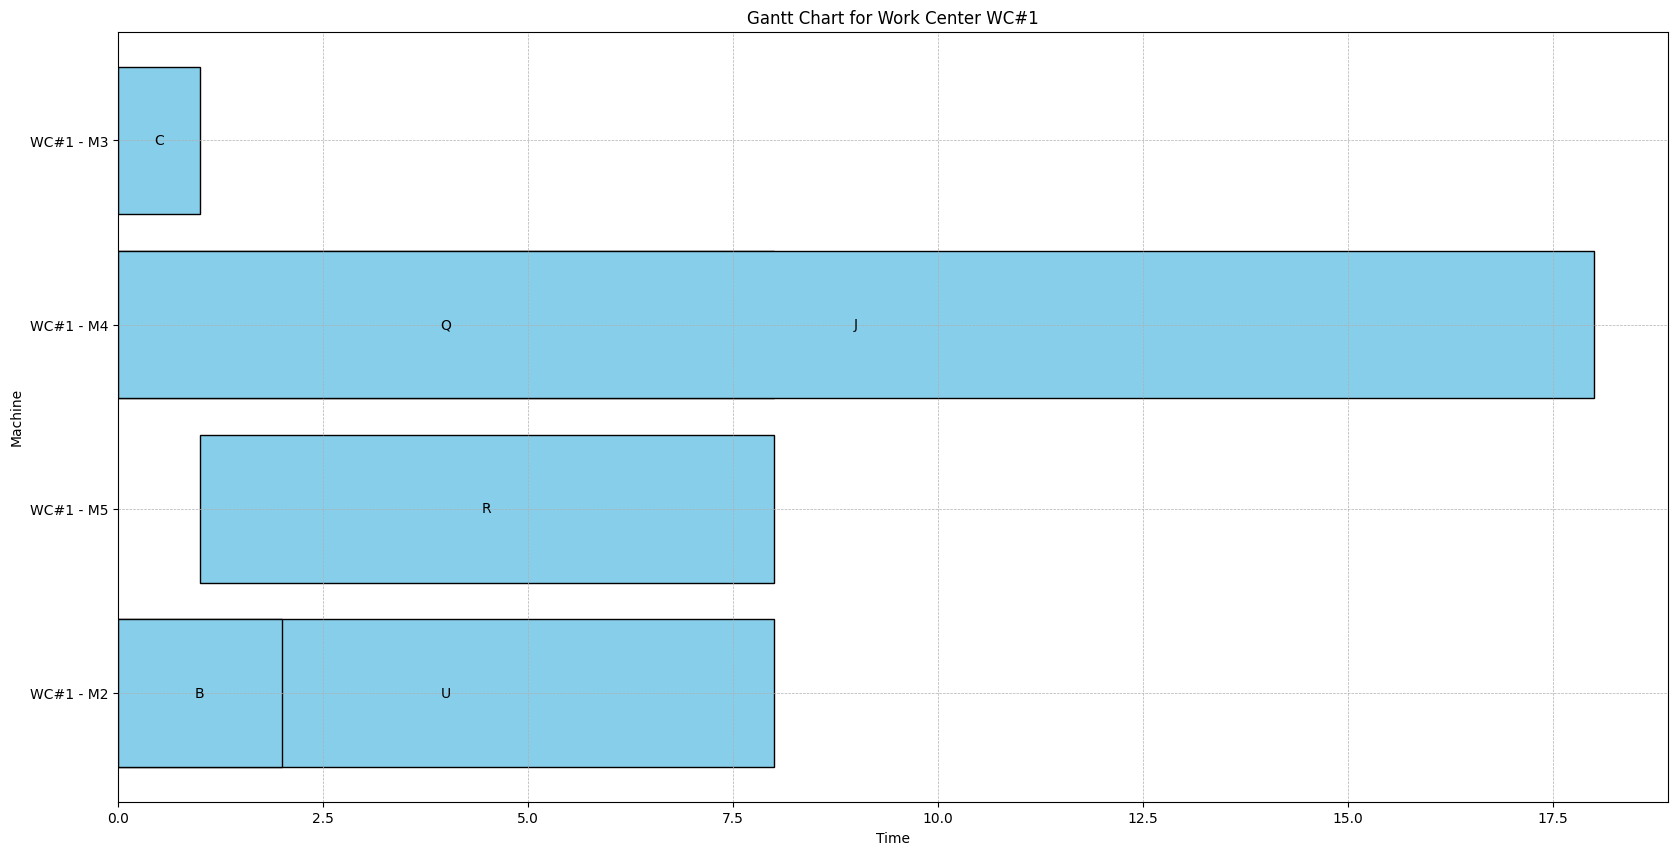

In [27]:
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [3, 2, 3],
    'M2': [2, 1, 2],
    'M3': [1, 2, 1],
    'M4': [1, 1, 1],
    'M5': [1, 2, 3]
})
display(df_machine)
factory = EDD_load_factory(df_machine)
operations = EDD_load_operations(df_BOM)
scheduled_operations = EDD_schedule_operations(operations, factory)
# Load operations from the DataFrame

# Plot the Gantt charts
plot_gantt_chart(scheduled_operations)
plot_gantt_chart_by_workcenters(scheduled_operations)


# print(scheduled_operations)


# df_schedule = LETSA_format_schedule(scheduled_operations)
# display(df_schedule)

# for key in factory: 
#     workcenter = factory[key]
#     print(workcenter.machines)

In [19]:
for operation in scheduled_operations: 
    print(operation.id, operation.scheduled_machine_idx)

A M1
H M1
P M2
U M1
K M3
R M2
Q M3
J M4
L M2
T M1
S M1
M M1
B M5
N M2
D M2
O M1
E M2
G M4
C M2
F None
I None


# SA

In [ ]:
# ==============
#       SA
# ==============
initial_temperature = 1000
cooling_rate = 0.8
min_temperature = 1
iterations_per_temp = 10

def SA_main(df_BOM, df_machine):
    # Create an initial schedule
    initial_schedule = SA_initial_solution(df_BOM)
    # print("Initial Schedule:", initial_schedule)

    # Test the revised evaluation function with machine availability
    initial_makespan, initial_usage = SA_calculate_makespan(initial_schedule, df_BOM, df_machine)
    # print("Initial Makespan with Machine Availability:", initial_makespan)

    # Run the simulated annealing algorithm
    best_schedule, best_makespan = simulated_annealing(df_BOM, df_machine, initial_schedule, initial_temperature, cooling_rate, min_temperature, iterations_per_temp)
    # print("Best Schedule:", best_schedule)
    # print("Best Makespan:", best_makespan)

    # Generate the Gantt chart for the best schedule
    # SA_generate_detailed_gantt_chart(best_schedule, df_BOM, best_makespan, df_machine)
    # SA_generate_beautified_gantt_chart(best_schedule, df_BOM, df_machine)

    # Export the best schedule to CSV
    return SA_format_schedule(best_schedule, df_BOM, df_machine)

def SA_initial_solution(df_BOM):
    schedule = []
    remaining_operations = set(df_BOM['operation'].tolist())
    
    while remaining_operations:
        for op in list(remaining_operations):
            predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]
            if all(pred in schedule for pred in predecessors):
                schedule.append(op)
                remaining_operations.remove(op)
    
    return schedule

def SA_calculate_makespan(schedule, df_BOM, df_machine):
    end_times = {}
    machine_availability = {
        workcenter: {machine: [0] * df_machine.loc[df_machine['workcenter'] == workcenter, machine].values[0]
                     for machine in df_machine.columns if machine != 'workcenter'}
        for workcenter in df_machine['workcenter']
    }
    workcenter_machine_usage = {
        workcenter: {machine: [] for machine in df_machine.columns if machine != 'workcenter'}
        for workcenter in df_machine['workcenter']
    }

    for op in schedule:
        machine = df_BOM[df_BOM['operation'] == op]['machine'].values[0]
        workcenter = df_BOM[df_BOM['operation'] == op]['workcenter'].values[0]
        processing_time = df_BOM[df_BOM['operation'] == op]['processing_time'].values[0]
        predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]

        # Calculate the earliest start time considering both predecessors and machine availability
        start_time = max([end_times.get(pred, 0) for pred in predecessors], default=0)
        
        # Find the earliest available machine in the workcenter
        earliest_machine_idx = min(range(len(machine_availability[workcenter][machine])), key=lambda x: machine_availability[workcenter][machine][x])
        start_time = max(start_time, machine_availability[workcenter][machine][earliest_machine_idx])

        # Calculate the end time of the operation
        end_time = start_time + processing_time
        end_times[op] = end_time

        # Update the machine availability and usage
        machine_availability[workcenter][machine][earliest_machine_idx] = end_time
        workcenter_machine_usage[workcenter][machine].append((start_time, end_time, op, earliest_machine_idx))

    return max(end_times.values()), workcenter_machine_usage

def SA_check_precedence_constraints(schedule, df_BOM):
    operation_positions = {op: idx for idx, op in enumerate(schedule)}
    for op in schedule:
        predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]
        if any(operation_positions[pred] >= operation_positions[op] for pred in predecessors):
            return False
    return True

def SA_generate_neighbor(schedule, df_BOM):
    new_schedule = schedule[:]
    while True:
        idx1, idx2 = random.sample(range(len(schedule)), 2)
        new_schedule[idx1], new_schedule[idx2] = new_schedule[idx2], new_schedule[idx1]
        if SA_check_precedence_constraints(new_schedule, df_BOM):
            break
        else:
            new_schedule = schedule[:]
    return new_schedule

def SA_accept_solution(current_makespan, new_makespan, temperature):
    if new_makespan < current_makespan:
        return True
    else:
        prob = np.exp((current_makespan - new_makespan) / temperature)
        return random.random() < prob

def simulated_annealing(df_BOM, df_machine, initial_schedule, initial_temperature, cooling_rate, min_temperature, iterations_per_temp):
    current_schedule = initial_schedule
    current_makespan, _ = SA_calculate_makespan(current_schedule, df_BOM, df_machine)
    best_schedule = current_schedule
    best_makespan = current_makespan
    temperature = initial_temperature
    # print(temperature)
    while temperature > min_temperature:
        for _ in range(iterations_per_temp):
            new_schedule = SA_generate_neighbor(current_schedule, df_BOM)
            new_makespan, _ = SA_calculate_makespan(new_schedule, df_BOM, df_machine)
            
            if SA_check_precedence_constraints(new_schedule, df_BOM) and SA_accept_solution(current_makespan, new_makespan, temperature):
                current_schedule = new_schedule
                current_makespan = new_makespan
                
                if new_makespan < best_makespan:
                    best_schedule = new_schedule
                    best_makespan = new_makespan
        # print(temperature)
        temperature *= cooling_rate
    return best_schedule, best_makespan

def SA_generate_detailed_gantt_chart(schedule, df_BOM, total_makespan, df_machine):
    _, workcenter_machine_usage = SA_calculate_makespan(schedule, df_BOM, df_machine)

    # Generate colors for each machine-workcenter combination
    unique_machines = df_BOM['machine'].unique()
    unique_workcenters = df_BOM['workcenter'].unique()
    color_palette = plt.cm.get_cmap('tab20', len(unique_machines) * len(unique_workcenters))
    color_index = 0
    colors = {}
    for wc in unique_workcenters:
        for machine in unique_machines:
            colors[(wc, machine)] = color_palette(color_index)
            color_index += 1

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(15, 10))

    y_ticks = []
    y_labels = []
    y_position = 0

    for wc in df_machine['workcenter']:
        for machine in df_machine.columns:
            if machine != 'workcenter':
                num_machines = df_machine.loc[df_machine['workcenter'] == wc, machine].values[0]
                for machine_idx in range(num_machines):
                    if (wc in workcenter_machine_usage) and (machine in workcenter_machine_usage[wc]):
                        for (start, end, op, used_machine_idx) in workcenter_machine_usage[wc][machine]:
                            if used_machine_idx == machine_idx:
                                ax.broken_barh([(start, end - start)], (y_position - 0.4, 0.8), facecolors=(colors[(wc, machine)]))
                                ax.text(start, y_position, f" {op} ({machine}-{machine_idx + 1})", va='center', ha='left')

                    y_ticks.append(y_position)
                    y_labels.append(f"{wc} {machine}-{machine_idx + 1}")
                    y_position += 1

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine - Workcenter')
    ax.grid(True)

    # Ensure the x-axis matches the total makespan
    ax.set_xlim(0, total_makespan)

    # Create a legend for the color-coded machine and workcenter
    legend_patches = [mpatches.Patch(color=colors[(wc, machine)], label=f'{wc} - {machine}')
                      for wc in unique_workcenters for machine in unique_machines]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

def SA_generate_beautified_gantt_chart(schedule, df_BOM, df_machine):
    schedule_data = []
    operation_end_times = {}
    machine_availability = {
        workcenter: {machine: [0] * df_machine.loc[df_machine['workcenter'] == workcenter, machine].values[0]
                     for machine in df_machine.columns if machine != 'workcenter'}
        for workcenter in df_machine['workcenter']
    }

    # Define a light color palette for each workcenter
    unique_workcenters = df_BOM['workcenter'].unique()
    color_palette = plt.cm.get_cmap('Pastel1', len(unique_workcenters))
    workcenter_colors = {workcenter: color_palette(i) for i, workcenter in enumerate(unique_workcenters)}

    for op in schedule:
        machine = df_BOM[df_BOM['operation'] == op]['machine'].values[0]
        workcenter = df_BOM[df_BOM['operation'] == op]['workcenter'].values[0]
        processing_time = df_BOM[df_BOM['operation'] == op]['processing_time'].values[0]
        predecessors = df_BOM[df_BOM['operation'] == op]['predecessor_operations'].values[0]

        # Calculate the earliest start time considering predecessors
        start_time = max([operation_end_times.get(pred, 0) for pred in predecessors], default=0)
        
        # Find the earliest available machine in the workcenter
        earliest_machine_idx = min(range(len(machine_availability[workcenter][machine])), key=lambda x: machine_availability[workcenter][machine][x])
        start_time = max(start_time, machine_availability[workcenter][machine][earliest_machine_idx])

        # Calculate the end time of the operation
        end_time = start_time + processing_time
        schedule_data.append({
            'Operation': op,
            'Start': start_time,
            'End': end_time,
            'Machine': machine,
            'Workcenter': workcenter,
            'Color': workcenter_colors[workcenter],
            'MachineIdx': earliest_machine_idx + 1
        })

        # Update the availability time for the machine in the workcenter
        machine_availability[workcenter][machine][earliest_machine_idx] = end_time
        operation_end_times[op] = end_time

    # Convert schedule data to DataFrame for plotting
    df_schedule = pd.DataFrame(schedule_data)

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(15, 10))

    for idx, row in df_schedule.iterrows():
        ax.broken_barh(
            [(row['Start'], row['End'] - row['Start'])],
            (idx - 0.4, 0.8),
            facecolors=(row['Color'])
        )
        ax.text(
            row['Start'] + 0.1,
            idx,
            f"{row['Operation']} ({row['Machine']}-{row['MachineIdx']})",
            va='center',
            ha='left',
            color='black'
        )

    ax.set_yticks(range(len(df_schedule)))
    ax.set_yticklabels(df_schedule['Operation'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.grid(True)

    # Ensure the x-axis matches the total makespan
    ax.set_xlim(0, df_schedule['End'].max())

    plt.show()

def SA_format_schedule(schedule, df_BOM, df_machine):
    max_makespan, workcenter_machine_usage = SA_calculate_makespan(schedule, df_BOM, df_machine)
    export_data = []

    # Gather utilized machines information
    used_machines = set()
    for wc in workcenter_machine_usage:
        for machine in workcenter_machine_usage[wc]:
            for (start, end, op, machine_idx) in workcenter_machine_usage[wc][machine]:
                used_machines.add((wc, machine, machine_idx))
                export_data.append({
                    'Operation': op,
                    'Start': start,
                    'End': end,
                    'Workcenter': wc,
                    'Machine': machine,
                    'MachineIdx': machine_idx + 1
                })



    # Add unused machines information
    for wc in df_machine['workcenter']:
        for machine in df_machine.columns:
            if machine != 'workcenter':
                num_machines = df_machine.loc[df_machine['workcenter'] == wc, machine].values[0]
                for idx in range(num_machines):
                    if (wc, machine, idx) not in used_machines:
                        export_data.append({
                            'Operation': None,
                            'Start': None,
                            'End': None,
                            'Workcenter': wc,
                            'Machine': machine,
                            'MachineIdx': idx + 1
                        })
    
    return pd.DataFrame(export_data)



# Systematic Testing

In [ ]:
import sys 
def print_progress_bar(iteration, total, length=50):
    if iteration == 0:
        return  # Don't print the progress bar when no progress has been made.
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r|{bar}| {percent}% Complete')
    sys.stdout.flush()
    if iteration == total:
        print()

In [ ]:
# GENERATING THE FACTORY INFORMATION
random.seed(42)
n_workcenters, n_machines = 3, 5
dict_machine = {}
dict_machine[0] = pd.DataFrame({ 'workcenter': [f"WC{i}" for i in range(1,n_workcenters+1)] })
dict_machine[1] = pd.DataFrame({ 'workcenter': [f"WC{i}" for i in range(1,n_workcenters+1)] })
dict_machine[2] = pd.DataFrame({ 'workcenter': [f"WC{i}" for i in range(1,n_workcenters+1)] })

for machine_no in range(1,n_machines+1):
    dict_machine[0][f"M{machine_no}"] = [random.randint(1,5) for _ in range(1,n_workcenters+1)]
    dict_machine[1][f"M{machine_no}"] = [random.randint(1,3) for _ in range(1,n_workcenters+1)]
    dict_machine[2][f"M{machine_no}"] = [random.randint(1,1) for _ in range(1,n_workcenters+1)]


files = os.listdir('TestCases') 
files = [file for file in files if file[-3:] == "csv"]
total_files = len(files)
df_results = pd.DataFrame({
    'filename': [None],
    'LETSA_time_0': [None],
    'LETSA_time_1': [None],
    'LETSA_time_2': [None],
    'EDD_time_0': [None],
    'EDD_time_1': [None],
    'EDD_time_2': [None],
    'SA_time_0': [None],
    'SA_time_1': [None],
    'SA_time_2': [None]
})

folder_path = 'LETSA_testcase'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for i, filename in enumerate(files): 
    df_BOM = pd.read_csv(f"TestCases//{filename}")
    # print("df_BOM")
    # display(df_BOM)
    df_BOM['predecessor_operations'] = df_BOM['predecessor_operations'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

    # LETSA
    for j in range(3): 
        # print(j)
        df_machine = dict_machine[j]
        # display(df_machine)

        # print("LETSA")
        start = time.time()
        factory = LETSA_load_factory(df_machine)
        operations = LETSA_load_operations(df_BOM)
        LETSA_scheduled_operations = LETSA_schedule_operations(operations, factory)
        end = time.time()
        LETSA_processing_time = end - start
        # print(LETSA_processing_time)

        # EDD
        # print("EDD")
        start = time.time()
        factory = EDD_load_factory(df_machine)
        operations = EDD_load_operations(df_BOM)
        EDD_scheduled_operations = EDD_schedule_operations(operations, factory)
        end = time.time()
        EDD_processing_time = end - start
        # print(EDD_processing_time)

        # SA
        # print("SA")
        start = time.time()
        SA_scheduled_operations = SA_main(df_BOM, df_machine)
        end = time.time()
        SA_processing_time = end - start 
        # print(SA_processing_time)

        df_results.at[i, f"LETSA_time_{j}"] = LETSA_processing_time
        df_results.at[i, f"EDD_time_{j}"] = EDD_processing_time
        df_results.at[i, f"SA_time_{j}"] = SA_processing_time

    df_results.at[i, "filename"] = filename

